Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Test Loss: 1.4174, Test Accuracy: 0.3466


Epoch 2/2, Test Loss: 1.0879, Test Accuracy: 0.5454


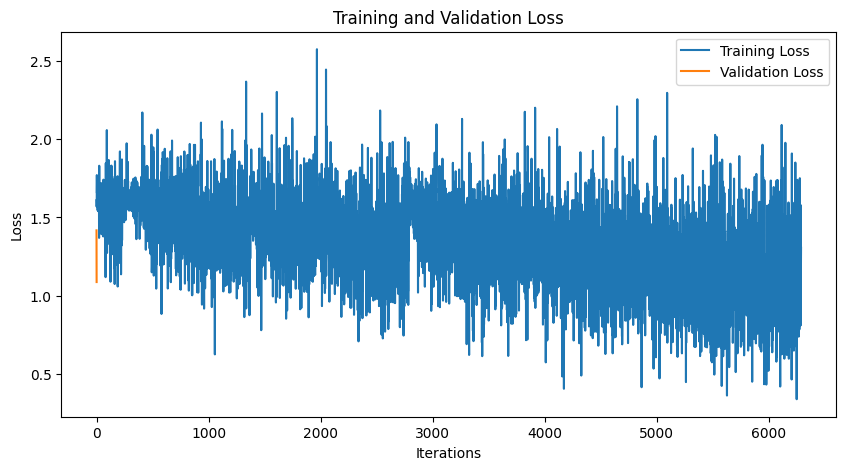

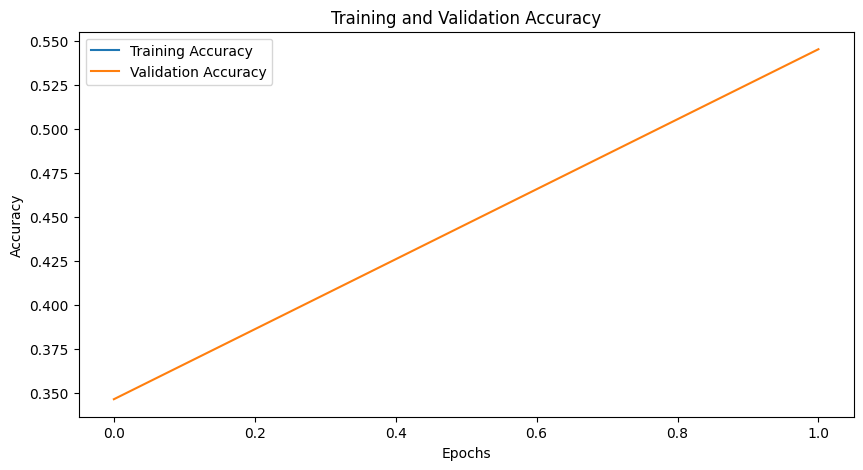

Model saved successfully at: ./mbert_sentiment_model
Classification Report:
                precision    recall  f1-score   support

      Negative       0.36      0.18      0.24      1317
       Neutral       0.76      0.79      0.77      1256
      Positive       0.53      0.49      0.51      1246
Mixed Feelings       0.57      0.84      0.68      1215
  Not_relevant       0.41      0.45      0.43      1253

      accuracy                           0.55      6287
     macro avg       0.53      0.55      0.53      6287
  weighted avg       0.52      0.55      0.52      6287



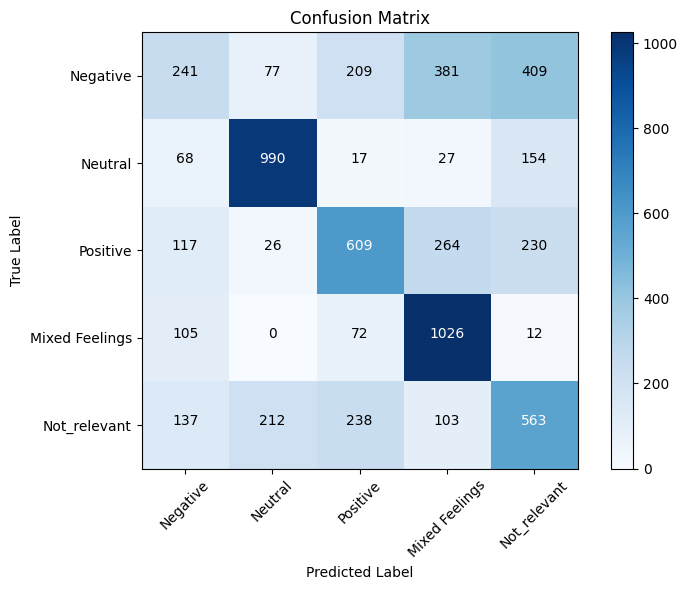

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('final_manglish.csv')

# Convert Sentiment Classes to Integers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Mixed Feelings': 3, 'Not_relevant': 4}
df['Sentiment_Class'] = df['Sentiment_Class'].map(label_mapping)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    df[df['Sentiment_Class'] == label_mapping['Positive']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Negative']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Not_relevant']],
    df[df['Sentiment_Class'] == label_mapping['Mixed Feelings']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Neutral']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True)
])

# Tokenization using M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoded_data_upsampled = tokenizer(data_upsampled['commentText'].tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

# Prepare target variable
labels_upsampled = torch.tensor(data_upsampled['Sentiment_Class'].values)

# Split the upsampled dataset
train_indices, test_indices = train_test_split(
    np.arange(len(encoded_data_upsampled.input_ids)),
    random_state=42,
    test_size=0.2
)

train_inputs = encoded_data_upsampled.input_ids[train_indices]
test_inputs = encoded_data_upsampled.input_ids[test_indices]
train_masks = encoded_data_upsampled.attention_mask[train_indices]
test_masks = encoded_data_upsampled.attention_mask[test_indices]
train_labels = labels_upsampled[train_indices]
test_labels = labels_upsampled[test_indices]

# Create DataLoader for train and test sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

# Load pre-trained M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_mapping))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 2
best_val_loss = float('inf')
patience = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training loop
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in progress_bar:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses_epoch = []
    val_preds_epoch = []
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
            val_loss = outputs.loss.item()
            val_losses_epoch.append(val_loss)
            _, val_preds = torch.max(outputs.logits, dim=1)
            val_preds_epoch.extend(val_preds.cpu().numpy())

    avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_acc = accuracy_score(test_labels.cpu().numpy(), val_preds_epoch)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_acc:.4f}')

    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience > 2:
            print("Early stopping triggered, no improvement in test loss.")
            break

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save the model
output_dir = './mbert_sentiment_model'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'tokenizer': tokenizer,
    'label_mapping': label_mapping
}, output_dir)

print("Model saved successfully at:", output_dir)

# Evaluate the model
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    inputs, masks, labels = batch
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_mapping.keys()))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions) 
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data from CSV
file_path = 'final_manglish_emoji.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['commentText'] = data['commentText'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and encoding using M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize and encode the texts
encoded_data = tokenizer(list(data_upsampled['commentText']), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Prepare target variable for upsampled data
labels_upsampled = torch.tensor(data_upsampled['Sentiment_Class'].values)

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_data.input_ids, labels_upsampled, test_size=0.05, random_state=0)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train, y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Build and move M-BERT model to GPU
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(sentiment_dict))
model.to(device)

# Fine-tune the model with progress bar
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model on test data
model.eval()
y_pred_labels = []
y_true_labels = []
for batch in tqdm(test_dataloader, desc='Evaluating'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, labels = batch
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    y_pred_labels.extend(predictions.tolist())
    y_true_labels.extend(labels.tolist())
    
    # Create reverse mapping of sentiment_dict
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}

# Move labels back to CPU for classification report
y_pred_labels = [reverse_sentiment_dict[label] for label in y_pred_labels]
y_true_labels = [reverse_sentiment_dict[label] for label in y_true_labels]

# Print complete classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=sentiment_dict.keys()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


                precision    recall  f1-score   support

      Positive       0.96      1.00      0.98       337
      Negative       0.83      0.95      0.89       272
  Not_relevant       0.93      0.86      0.89       320
Mixed Feelings       0.87      0.83      0.85       319
       Neutral       0.93      0.90      0.91       324

      accuracy                           0.91      1572
     macro avg       0.90      0.91      0.90      1572
  weighted avg       0.91      0.91      0.90      1572

